In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.transforms import ToTensor, Compose
from tabulate import tabulate

In [2]:
train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=Compose([ToTensor()]),
    download=True,
)
test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=Compose([ToTensor()]),
    download=True)

In [3]:
def show_images(dataset, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        image, label = dataset[i]
        plt.subplot(1, num_images, i+1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

Sample Images from Training Dataset

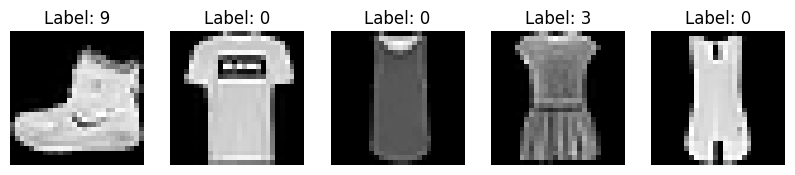

In [4]:
show_images(train_dataset)

Sample Images from Testing Dataset

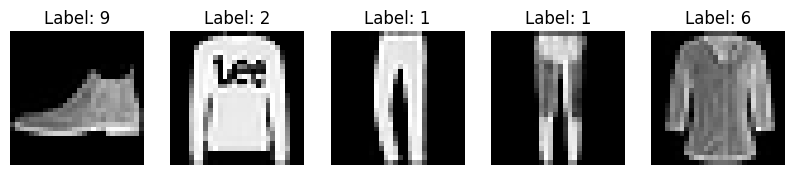

In [5]:
show_images(test_dataset)

In [6]:
os.makedirs('records',exist_ok=True)

Functions to initialize weight

In [7]:
def initialize_weights_hf(model):
    with torch.no_grad():
        weights = torch.FloatTensor([[
            [1, 0, 0], [0, 1, 0], [0, 0, 1]],
            [[0, 0, 1], [0, 1, 0], [1, 0, 0]],
            [[0, 1, 0], [0, 1, 0], [0, 1, 0]],
            [[0, 0, 0], [1, 1, 1], [0, 0, 0]]])

        weights = weights.view(4, 1, 3, 3)
        model.conv1.weight = nn.Parameter(weights, requires_grad=False)
        
        return model

def initialize_weights_ht(model):
    with torch.no_grad():
        weights = torch.FloatTensor([[
            [1, 0, 0], [0, 1, 0], [0, 0, 1]],
            [[0, 0, 1], [0, 1, 0], [1, 0, 0]],
            [[0, 1, 0], [0, 1, 0], [0, 1, 0]],
            [[0, 0, 0], [1, 1, 1], [0, 0, 0]]])
        bias = torch.FloatTensor([0, 0, 0, 0])

        weights = weights.view(4, 1, 3, 3)
        bias = bias.view(4)

        model.conv1.weight = nn.Parameter(weights, requires_grad=True)
        model.conv1.bias = nn.Parameter(bias, requires_grad=True)
        
        return model

def initialize_weights_default(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight.data)
            nn.init.normal_(m.bias.data, 0, 1)
        
    return model

Support functions

In [17]:
def train_loop(data, model, loss_fn, optimizer, batch_size=64):
    dataloader = DataLoader(data, batch_size=batch_size)
    size = len(dataloader.dataset)
    
    loss_history = []
    correct = 0
    
    for _, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    accuracy = correct / size
    return loss_history, accuracy

def test_loop(data, model, loss_fn, batch_size=64):
    dataloader = DataLoader(data, batch_size)
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    loss_history = []

    with torch.no_grad():
      for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        test_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        loss_history.append(loss.item())

    test_loss /= num_batches
    correct /= size
    
    return loss_history, correct

def save_experiment(model, train_loss_history, test_loss_history, train_acc_history, test_acc_history, filename):
    model_path = os.path.join('records', filename)
    torch.save({'model_weights': model.state_dict()}, model_path)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(train_loss_history, label='Training Loss')
    ax[0].plot(test_loss_history, label='Testing Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss Over Epochs')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(train_acc_history, label='Training Accuracy')
    ax[1].plot(test_acc_history, label='Testing Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy Over Epochs')
    ax[1].legend()
    ax[1].grid(True)

    plot_path = os.path.join('records', f'{filename}_results.png')
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.show()
    
def make_experiment(cnn, filename, loss_fn, optimizer, epochs=40):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    stats_for_print = []
    
    for _ in tqdm(range(epochs)):
        train_loss, train_acc = train_loop(train_dataset, cnn, loss_fn, optimizer)
        test_loss, test_acc = test_loop(test_dataset, cnn, loss_fn)
        
        train_loss_history.append(sum(train_loss) / len(train_loss))
        test_loss_history.append(sum(test_loss) / len(test_loss))
        train_acc_history.append(train_acc)
        test_acc_history.append(test_acc)
        stats_for_print.append([_ + 1, train_acc, sum(train_loss) / len(train_loss), test_acc, sum(test_loss) / len(test_loss)])

    print(tabulate(stats_for_print, headers=["Epoch", "Train acc", "Train loss", "Test acc", "Test loss"], tablefmt="fancy_grid"))
    save_experiment(cnn, train_loss_history, test_loss_history, train_acc_history, test_acc_history, filename)

# Define CNN A1 + Experiments

In [9]:
class CNN_A1(nn.Module):
    def __init__(self):
        super(CNN_A1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(4 * 28 * 28, 128)
        
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

100%|███████████████████████████████████████████| 20/20 [01:20<00:00,  4.04s/it]


╒═════════╤═════════════╤══════════════╤════════════╤═════════════╕
│   Epoch │   Train acc │   Train loss │   Test acc │   Test loss │
╞═════════╪═════════════╪══════════════╪════════════╪═════════════╡
│       1 │    0.339417 │      2.20367 │     0.5466 │     2.07905 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       2 │    0.634    │      1.9794  │     0.6557 │     1.91448 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       3 │    0.666883 │      1.87923 │     0.6656 │     1.86028 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       4 │    0.67325  │      1.84105 │     0.6703 │     1.83354 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       5 │    0.68385  │      1.81714 │     0.6957 │     1.81104 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       6 │    0.7203   │      1.79408 │     0.7231 │     1.78926 │
├─────────┼─────────────┼──────────────┼────────

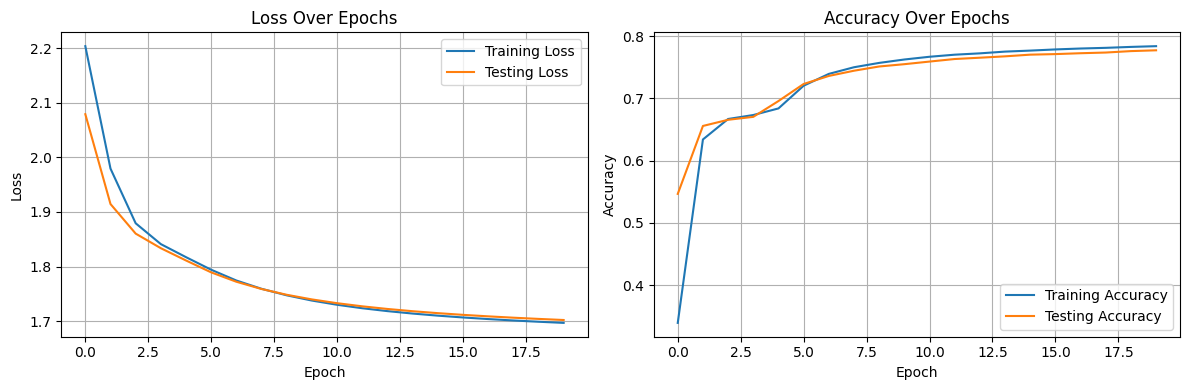

In [10]:
loss_fn = nn.CrossEntropyLoss()
cnn_1_hf = initialize_weights_hf(CNN_A1())
optimizer = torch.optim.SGD(cnn_1_hf.parameters(), lr=0.001)

make_experiment(cnn_1_hf, 'cnn_1_hf', loss_fn, optimizer)

100%|███████████████████████████████████████████| 20/20 [01:52<00:00,  5.61s/it]


╒═════════╤═════════════╤══════════════╤════════════╤═════════════╕
│   Epoch │   Train acc │   Train loss │   Test acc │   Test loss │
╞═════════╪═════════════╪══════════════╪════════════╪═════════════╡
│       1 │    0.398367 │      2.19175 │     0.5482 │     2.05251 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       2 │    0.5814   │      1.97433 │     0.5874 │     1.93311 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       3 │    0.596217 │      1.90967 │     0.5949 │     1.89867 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       4 │    0.625083 │      1.873   │     0.6694 │     1.84231 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       5 │    0.6912   │      1.818   │     0.703  │     1.80763 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       6 │    0.7205   │      1.78971 │     0.7197 │     1.78455 │
├─────────┼─────────────┼──────────────┼────────

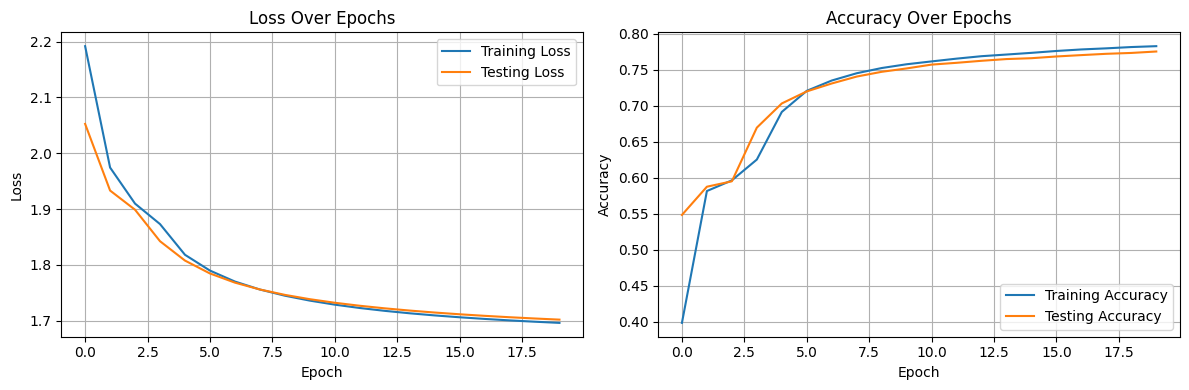

In [11]:
loss_fn = nn.CrossEntropyLoss() # Initialize the loss function
cnn_1_ht = initialize_weights_ht(CNN_A1())
optimizer = torch.optim.SGD(cnn_1_ht.parameters(), lr=0.001)

make_experiment(cnn_1_ht, 'cnn_1_ht', loss_fn, optimizer)

100%|███████████████████████████████████████████| 20/20 [01:47<00:00,  5.36s/it]


╒═════════╤═════════════╤══════════════╤════════════╤═════════════╕
│   Epoch │   Train acc │   Train loss │   Test acc │   Test loss │
╞═════════╪═════════════╪══════════════╪════════════╪═════════════╡
│       1 │    0.11715  │      2.34349 │     0.1359 │     2.32479 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       2 │    0.149567 │      2.31106 │     0.1606 │     2.30009 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       3 │    0.16525  │      2.29519 │     0.1681 │     2.29271 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       4 │    0.17105  │      2.28951 │     0.1718 │     2.28846 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       5 │    0.175467 │      2.28516 │     0.1762 │     2.28429 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       6 │    0.1801   │      2.28063 │     0.1787 │     2.28165 │
├─────────┼─────────────┼──────────────┼────────

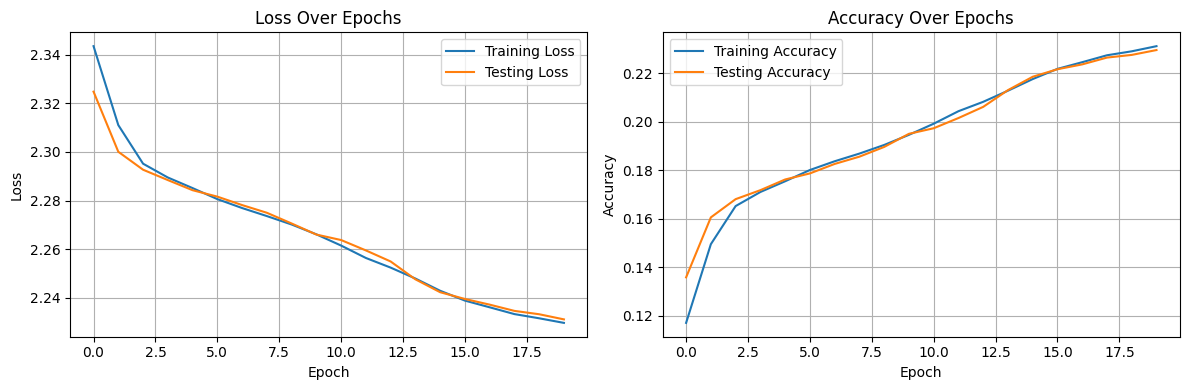

In [12]:
loss_fn = nn.CrossEntropyLoss()
cnn_1_default = initialize_weights_default(CNN_A1())
optimizer = torch.optim.SGD(cnn_1_default.parameters(), lr=0.001)

make_experiment(cnn_1_default, 'cnn_1_default', loss_fn, optimizer)

# Define CNN A2 + Experiments

In [13]:
class CNN_A2(nn.Module):
    def __init__(self, additional_conv_layers=0):
        super(CNN_A2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
        
        self.additional_convs = nn.ModuleList()
        for _ in range(additional_conv_layers):
            self.additional_convs.append(nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=1))
        
        self.fc1 = nn.Linear(8 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        for conv in self.additional_convs:
            x = conv(x)
            x = F.relu(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

100%|███████████████████████████████████████████| 20/20 [04:09<00:00, 12.45s/it]


╒═════════╤═════════════╤══════════════╤════════════╤═════════════╕
│   Epoch │   Train acc │   Train loss │   Test acc │   Test loss │
╞═════════╪═════════════╪══════════════╪════════════╪═════════════╡
│       1 │    0.27015  │      2.25789 │     0.387  │     2.15211 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       2 │    0.591067 │      1.97015 │     0.6569 │     1.85789 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       3 │    0.671933 │      1.82684 │     0.6703 │     1.81534 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       4 │    0.69     │      1.79483 │     0.7192 │     1.77628 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       5 │    0.73975  │      1.75379 │     0.7433 │     1.74639 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       6 │    0.754083 │      1.73162 │     0.7522 │     1.72981 │
├─────────┼─────────────┼──────────────┼────────

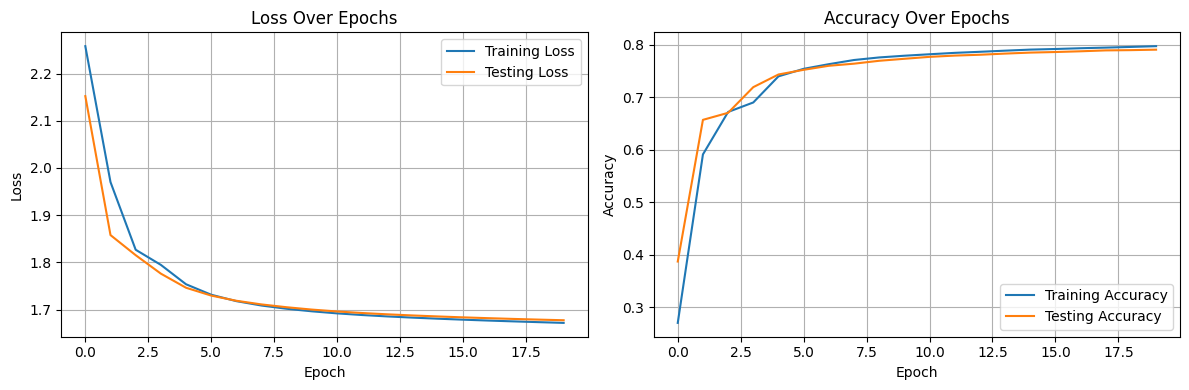

In [14]:
loss_fn = nn.CrossEntropyLoss()
cnn_2_hf = initialize_weights_hf(CNN_A2())
optimizer = torch.optim.SGD(cnn_2_hf.parameters(), lr=0.001)

make_experiment(cnn_2_hf, 'cnn_2_hf', loss_fn, optimizer)

100%|███████████████████████████████████████████| 20/20 [04:34<00:00, 13.71s/it]


╒═════════╤═════════════╤══════════════╤════════════╤═════════════╕
│   Epoch │   Train acc │   Train loss │   Test acc │   Test loss │
╞═════════╪═════════════╪══════════════╪════════════╪═════════════╡
│       1 │    0.2872   │      2.26755 │     0.4573 │     2.17685 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       2 │    0.571917 │      1.99082 │     0.6173 │     1.88527 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       3 │    0.622817 │      1.8633  │     0.6605 │     1.83587 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       4 │    0.673167 │      1.81332 │     0.6716 │     1.80246 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       5 │    0.716467 │      1.77248 │     0.7272 │     1.75922 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       6 │    0.7452   │      1.7396  │     0.7482 │     1.73483 │
├─────────┼─────────────┼──────────────┼────────

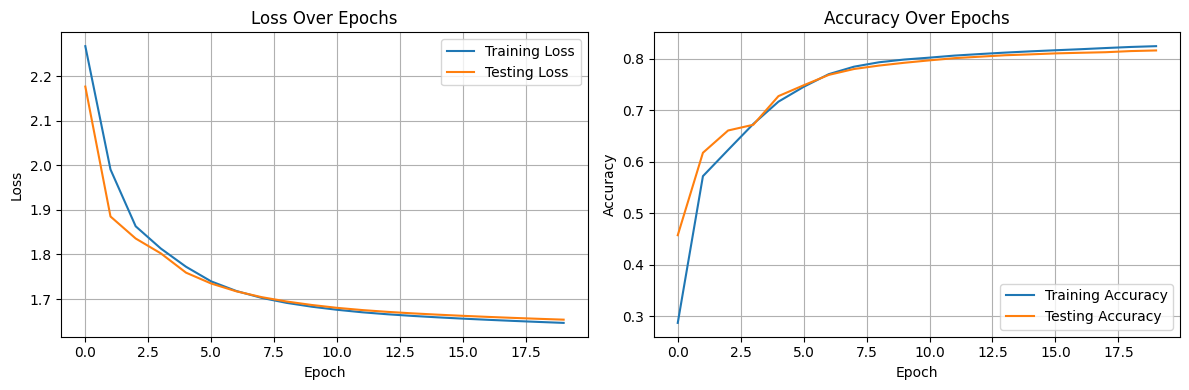

In [15]:
loss_fn = nn.CrossEntropyLoss()
cnn_2_ht = initialize_weights_ht(CNN_A2())
optimizer = torch.optim.SGD(cnn_2_ht.parameters(), lr=0.001)

make_experiment(cnn_2_ht, 'cnn_2_ht', loss_fn, optimizer)

100%|███████████████████████████████████████████| 40/40 [09:00<00:00, 13.52s/it]


╒═════════╤═════════════╤══════════════╤════════════╤═════════════╕
│   Epoch │   Train acc │   Train loss │   Test acc │   Test loss │
╞═════════╪═════════════╪══════════════╪════════════╪═════════════╡
│       1 │   0.0924667 │      2.36868 │     0.093  │     2.36824 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       2 │   0.09435   │      2.36677 │     0.0948 │     2.36649 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       3 │   0.09695   │      2.36418 │     0.097  │     2.36431 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       4 │   0.0973167 │      2.36381 │     0.097  │     2.36431 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       5 │   0.0977    │      2.36343 │     0.0974 │     2.36393 │
├─────────┼─────────────┼──────────────┼────────────┼─────────────┤
│       6 │   0.0980667 │      2.36307 │     0.0978 │     2.36351 │
├─────────┼─────────────┼──────────────┼────────

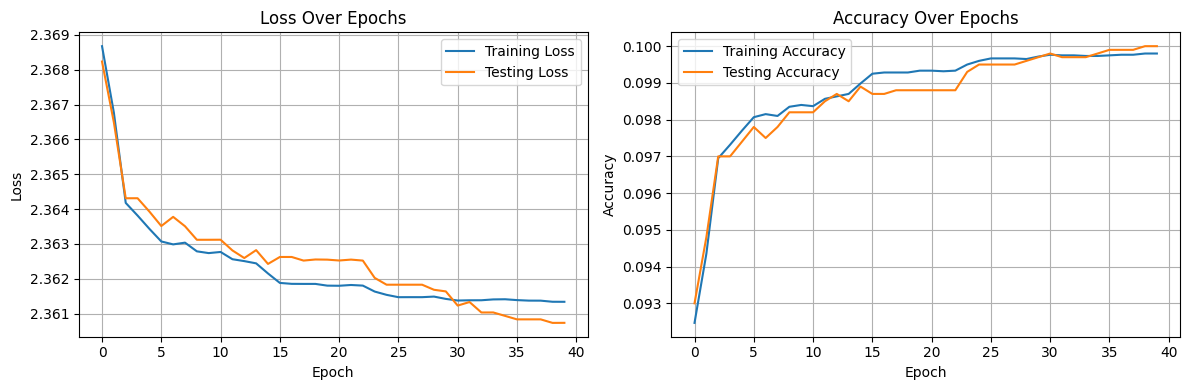

In [18]:
loss_fn = nn.CrossEntropyLoss()
cnn_2_default = initialize_weights_default(CNN_A2())
optimizer = torch.optim.SGD(cnn_2_default.parameters(), lr=0.001)

make_experiment(cnn_2_default, 'cnn_2_default', loss_fn, optimizer)